# 3-1 低阶API示范
下面的范例使用Pytorch的低阶API实现线性回归模型和DNN二分类

低阶API主要包括：
* 张量操作
* 计算图
* 自动微分

## 一、线性回归模型

### 1.准备数据

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# 样本数量
n = 400

# 生成测试用的数据集
x = 10*torch.rand([n, 2]) - 5.0
w0 = torch.tensor([[2.], [3]])
b0 = torch.tensor([[10.]])
y = x@w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])

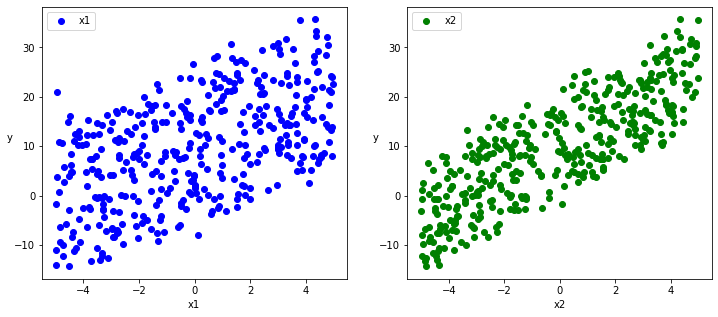

In [3]:
# 数据可视化, 这里有两个变量, 所以subplot两个图
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0].numpy(), y.numpy(), c="b")
ax1.legend(["x1"])
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1].numpy(), y.numpy(), c="g")
ax2.legend(["x2"])
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

### 这里的代码是利用高阶API写的, 所以只是测一下

In [4]:
# 构建数据集
class LinearDataset(Dataset):
    # 这里可以用TensorDataset代替
    def __init__(self, features, labels):
        super().__init__()
        self.features = features
        self.labels = labels

    def __getitem__(self, pos):
        return (self.features[pos, :], self.labels[pos, :])

    def __len__(self):
        # 在此处必须实现len方法
        return len(self.features)

In [5]:
# 测试数据集效果
batch_size = 8
linear_dataset = LinearDataset(x, y)
dl_train = DataLoader(linear_dataset, batch_size=batch_size)

for fs, ls in dl_train:
    print(fs, ls)
    break

tensor([[-0.3644,  2.4941],
        [ 4.4523,  4.1681],
        [-1.4256,  4.0330],
        [ 0.0565, -1.3218],
        [-2.7937,  3.9170],
        [ 4.7312, -2.1869],
        [ 3.6993,  1.7198],
        [ 1.6485,  1.8528]]) tensor([[17.4514],
        [29.3214],
        [18.2918],
        [12.6354],
        [16.7873],
        [14.4222],
        [23.9768],
        [14.4503]])


In [6]:
# 构建数据管道迭代器, 低阶API实现
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱indices
    np.random.shuffle(indices)
    # 按照batch进行yield
    for i in range(0, num_examples, batch_size):
        idxs = torch.LongTensor(indices[i: min(i+batch_size, num_examples-1)])
        yield features.index_select(0, idxs), labels.index_select(0, idxs)

In [7]:
# 测试管道效果
batch_size = 8
(features, labels) = next(data_iter(x, y, batch_size))
(features, labels) = next(data_iter(x, y, batch_size))
print(features)
print(labels)

tensor([[-3.0480,  3.1920],
        [-3.0531, -0.1711],
        [-1.8963,  2.7119],
        [-0.8131,  2.8726],
        [-0.0086, -2.4272],
        [ 3.6763, -3.9587],
        [ 2.8283,  2.9005],
        [ 0.5580,  2.6358]])
tensor([[13.2595],
        [ 4.2323],
        [10.3250],
        [16.7792],
        [ 4.1949],
        [ 4.8910],
        [23.3232],
        [17.1684]])


### 2.定义模型

In [8]:
# 定义模型, 注意: 这里用的是低阶API
class LinearRegression:

    def __init__(self):
        super().__init__()
        self.w = torch.randn_like(w0, requires_grad=True)
        self.b = torch.zeros_like(b0, requires_grad=True)

    def forward(self, x):
        # 正向传播
        return x@self.w + self.b

    def loss_func(self, y_pred, y_true):
        return torch.mean((y_pred-y_true)**2)/2

In [9]:
model = LinearRegression()

### 3. 训练模型

In [10]:
def train_step(model, features, labels, lr=0.0001):
    # 正向传播计算损失
    pred = model.forward(features)
    loss = model.loss_func(pred, labels)

    # 反向传播更新参数
    loss.backward()
    with torch.no_grad():
        # 更新参数的时候不用记录梯度
        model.w -= lr*model.w.grad
        model.b -= lr*model.b.grad
        # 更新完成之后需要清除梯度
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [11]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(x, y, batch_size))
train_step(model,features,labels)

tensor(73.5351, grad_fn=<DivBackward0>)

In [12]:
def train_model(model, epochs, batch_size=10, lr=0.0001):
    for epoch in range(1, epochs+1):
        for features, labels in data_iter(x, y, batch_size):
            loss = train_step(model, features, labels, lr)
        
        if epoch%200 == 0:
            print("====================")
            print("epoch:{:d}, loss:{:.3f}".format(epoch, loss.item()))
            print("model.w:", model.w.detach())
            print("model.b:", model.b.detach())

In [13]:
# 猴子补丁
LinearRegression.train_model = train_model

In [14]:
model.train_model(1000)

epoch:200, loss:13.046
model.w: tensor([[2.0188],
        [2.9206]])
model.b: tensor([[5.5527]])
epoch:400, loss:5.113
model.w: tensor([[2.0148],
        [2.9619]])
model.b: tensor([[8.0590]])
epoch:600, loss:0.744
model.w: tensor([[2.0113],
        [2.9806]])
model.b: tensor([[9.1869]])
epoch:800, loss:0.786
model.w: tensor([[2.0101],
        [2.9884]])
model.b: tensor([[9.6947]])
epoch:1000, loss:1.212
model.w: tensor([[2.0094],
        [2.9927]])
model.b: tensor([[9.9230]])


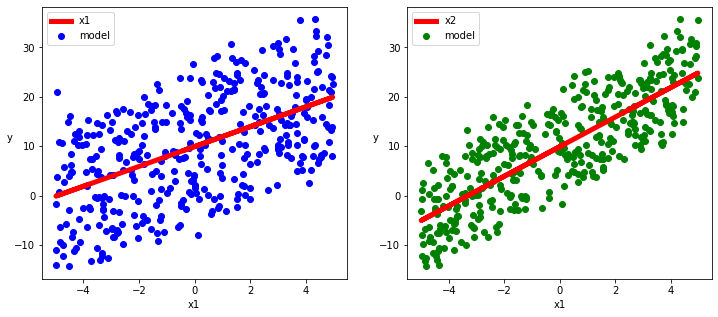

In [15]:
# 结果可视化
plt.figure(figsize=(12, 5))
# 绘制x1
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0].numpy(), y, c="b", label="x1")
y1_pred = (x[:, [0]] @ model.w[[0], :].detach() + model.b.detach()).numpy()
ax1.plot(x[:, 0].numpy(), y1_pred, "-r", linewidth=5.0, label="model")
plt.xlabel("x1")
plt.ylabel("y", rotation=0)
plt.legend(["x1", "model"])
# 绘制x2
ax2 = plt.subplot(122)
ax2.scatter(x[:, 1].numpy(), y, c="g", label="x2")
y2_pred = (x[:, [1]] @ model.w[[1], :].detach() + model.b.detach()).numpy()
ax2.plot(x[:, 1].numpy(), y2_pred, "-r", linewidth=5.0, label="model")
plt.xlabel("x1")
plt.ylabel("y", rotation=0)
plt.legend(["x2", "model"])

plt.show()


## 二、DNN二分类

### 1.准备数据

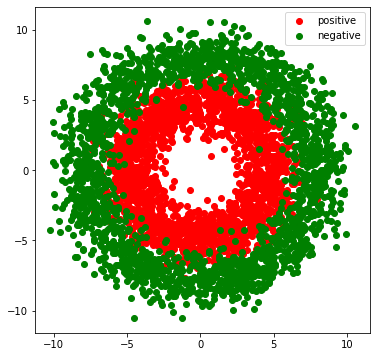

In [16]:
# 定义正负样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0, 1.0, size=[n_positive, 1])
theta_p = 2*np.pi*torch.rand([n_positive, 1])
xp = torch.cat([r_p*torch.cos(theta_p), r_p*torch.sin(theta_p)], axis=1)
yp = torch.ones_like(r_p)

# 生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0, 1.0, size=[n_negative, 1])
theta_n = 2*np.pi*torch.rand([n_negative, 1])
xn = torch.cat([r_n*torch.cos(theta_n), r_n*torch.sin(theta_n)], axis=1)
yn = torch.zeros_like(r_n)

# 汇总样本
x = torch.cat([xp, xn], axis=0)
y = torch.cat([yp, yn], axis=0)

# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(xp[:, 0].numpy(), xp[:, 1].numpy(), c="r")
plt.scatter(xn[:, 0].numpy(), xn[:, 1].numpy(), c="g")
plt.legend(["positive", "negative"])
plt.show()

### 2.定义模型
此处用nn.Module来组织模型

In [17]:
class DNNModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = nn.Parameter(torch.randn(2, 4))
        self.b1 = nn.Parameter(torch.randn(1, 4))
        self.w2 = nn.Parameter(torch.randn(4, 8))
        self.b2 = nn.Parameter(torch.randn(1, 8))
        self.w3 = nn.Parameter(torch.randn(8, 1))
        self.b3 = nn.Parameter(torch.randn(1, 1))
        
    def forward(self, x):
        x = torch.relu(x @ self.w1 + self.b1)
        x = torch.relu(x @ self.w2 + self.b2)
        y = torch.sigmoid(x @ self.w3 + self.b3)
        return y
    
    # 定义损失函数, 二元交叉熵损失
    def loss_func(self, y_pred, y_true):
        eps = 1e-7
        # 限制y_pred范围, 防止取对数出错
        y_pred = torch.clamp(y_pred, eps, 1-eps)
        bce = - y_true*torch.log(y_pred) - (1-y_true)*torch.log(1-y_pred)
        return torch.mean(bce)
    
    def metric_func(self, y_pred, y_true):
        """指标函数计算accuracy
        """
        y_pred = torch.where(y_pred>0.5,
                             torch.ones_like(y_pred, dtype=torch.float32),
                             torch.zeros_like(y_pred, dtype=torch.float32))
        acc = 1 - torch.mean(torch.abs(y_pred-y_true))
        return acc

In [18]:
model = DNNModel()

In [19]:
# 测试模型
batch_size = 10
(features, labels) = next(data_iter(x, y, batch_size=batch_size))

predictions = model(features)

loss = model.loss_func(predictions, labels)
metric = model.metric_func(predictions, labels)

print("init loss:", loss.item())
print("init metric:", metric.item())

init loss: 3.488511323928833
init metric: 0.699999988079071


### 3.训练模型

In [20]:
def train_step(model, features, labels):
    # 正向传播, 计算损失
    pred = model.forward(features)
    loss = model.loss_func(pred, labels)
    metric = model.metric_func(pred, labels)
    
    # 反向传播求更新梯度
    loss.backward()
    for param in model.parameters():
        # 重新赋值避免梯度记录
        param.data = (param.detach() - 0.01*param.grad.detach())
    
    # 梯度清0
    model.zero_grad()
    return loss.item(), metric.item()

In [21]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_list, metric_list = [], []
        for features, labels in data_iter(x, y, batch_size):
            lossi, metrici = train_step(model, features, labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)
        
        if epoch%100 == 0:
            print("epoch = {:d}, loss = {:.3f}, metric = {:.3f}".format(epoch, loss, metric))
            

In [22]:
DNNModel.train_model = train_model

In [23]:
model.train_model(epochs=1000)  # 200个epochs暂停

epoch = 100, loss = 0.189, metric = 0.926
epoch = 200, loss = 0.186, metric = 0.923


KeyboardInterrupt: 

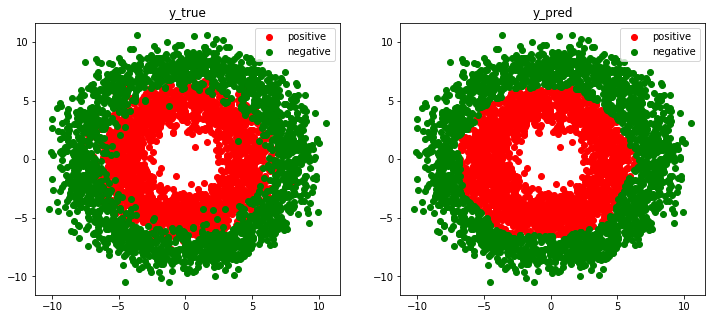

In [24]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(xp[:,0],xp[:,1], c="r")
ax1.scatter(xn[:,0],xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = x[torch.squeeze(model.forward(x)>=0.5)]
Xn_pred = x[torch.squeeze(model.forward(x)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");